# Lecture 3A - The Dicke model 

Author: J. R. Johansson (robert@riken.jp), https://jrjohansson.github.io/

This lecture series was developed by J.R. Johansson. The original lecture notebooks are available [here](https://github.com/jrjohansson/qutip-lectures).

This is a slightly modified version of the lectures, to work with the current release of QuTiP. You can find these lectures as a part of the [qutip-tutorials repository](https://github.com/qutip/qutip-tutorials). This lecture and other tutorial notebooks are indexed at the [QuTiP Tutorial webpage](https://qutip.org/tutorials.html).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qutip import (about, destroy, entropy_vn, expect, hinton, jmat, ptrace,
                   qeye, steadystate, tensor, wigner)

%matplotlib inline

## Introduction

The Dicke Hamiltonian consists of a cavity mode and $N$ spin-1/2 coupled to the cavity:

<center>
$\displaystyle H_D = \omega_0 \sum_{i=1}^N \sigma_z^{(i)} + \omega a^\dagger a + \sum_{i}^N \frac{\lambda}{\sqrt{N}}(a + a^\dagger)(\sigma_+^{(i)}+\sigma_-^{(i)})$

$\displaystyle H_D = \omega_0 J_z + \omega a^\dagger a +  \frac{\lambda}{\sqrt{N}}(a + a^\dagger)(J_+ + J_-)$
</center>
    
where $J_z$ and $J_\pm$ are the collective angular momentum operators for a pseudospin of length $j=N/2$ :

<center>
$\displaystyle J_z = \sum_{i=1}^N \sigma_z^{(i)}$

$\displaystyle J_\pm = \sum_{i=1}^N \sigma_\pm^{(i)}$
</center>

### References

 * [R.H. Dicke, Phys. Rev. 93, 99–110 (1954)](https://journals.aps.org/pr/abstract/10.1103/PhysRev.93.99)

## Setup problem in QuTiP

In [2]:
w = 1.0
w0 = 1.0

g = 1.0
gc = np.sqrt(w * w0) / 2  # critical coupling strength

kappa = 0.05
gamma = 0.15

In [3]:
M = 16
N = 4
j = N / 2
n = 2 * j + 1

a = tensor(destroy(M), qeye(int(n)))
Jp = tensor(qeye(M), jmat(j, "+"))
Jm = tensor(qeye(M), jmat(j, "-"))
Jz = tensor(qeye(M), jmat(j, "z"))

H0 = w * a.dag() * a + w0 * Jz
H1 = 1.0 / np.sqrt(N) * (a + a.dag()) * (Jp + Jm)
H = H0 + g * H1

H

Quantum object: dims=[[16, 5], [16, 5]], shape=(80, 80), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 2.  0.  0. ...  0.  0.  0.]
 [ 0.  1.  0. ...  0.  0.  0.]
 [ 0.  0.  0. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... 15.  0.  0.]
 [ 0.  0.  0. ...  0. 14.  0.]
 [ 0.  0.  0. ...  0.  0. 13.]]

### Structure of the Hamiltonian

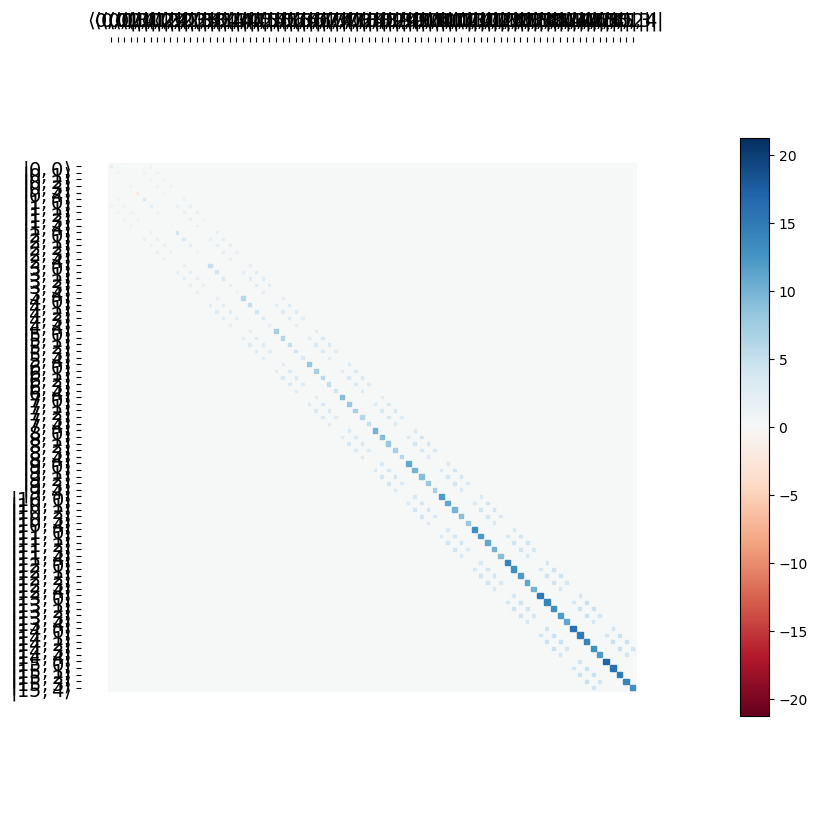

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
hinton(H, ax=ax);

## Find the ground state as a function of cavity-spin interaction strength

In [5]:
g_vec = np.linspace(0.01, 1.0, 20)

# Ground state and steady state for the Hamiltonian: H = H0 + g * H1
psi_gnd_list = [(H0 + g * H1).groundstate()[1] for g in g_vec]

## Cavity ground state occupation probability

In [6]:
n_gnd_vec = expect(a.dag() * a, psi_gnd_list)
Jz_gnd_vec = expect(Jz, psi_gnd_list)

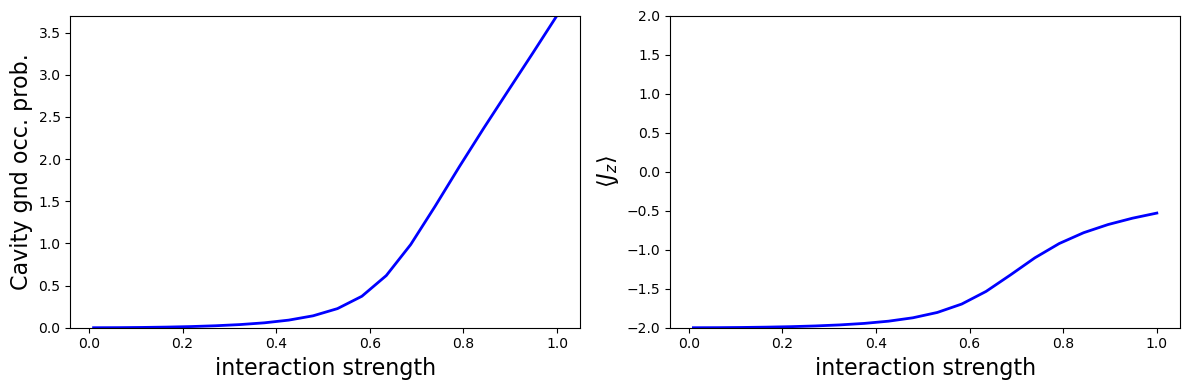

In [7]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(12, 4))

axes[0].plot(g_vec, n_gnd_vec, "b", linewidth=2, label="cavity occupation")
axes[0].set_ylim(0, max(n_gnd_vec))
axes[0].set_ylabel("Cavity gnd occ. prob.", fontsize=16)
axes[0].set_xlabel("interaction strength", fontsize=16)

axes[1].plot(g_vec, Jz_gnd_vec, "b", linewidth=2, label="cavity occupation")
axes[1].set_ylim(-j, j)
axes[1].set_ylabel(r"$\langle J_z\rangle$", fontsize=16)
axes[1].set_xlabel("interaction strength", fontsize=16)

fig.tight_layout()

## Cavity Wigner function and Fock distribution as a function of coupling strength

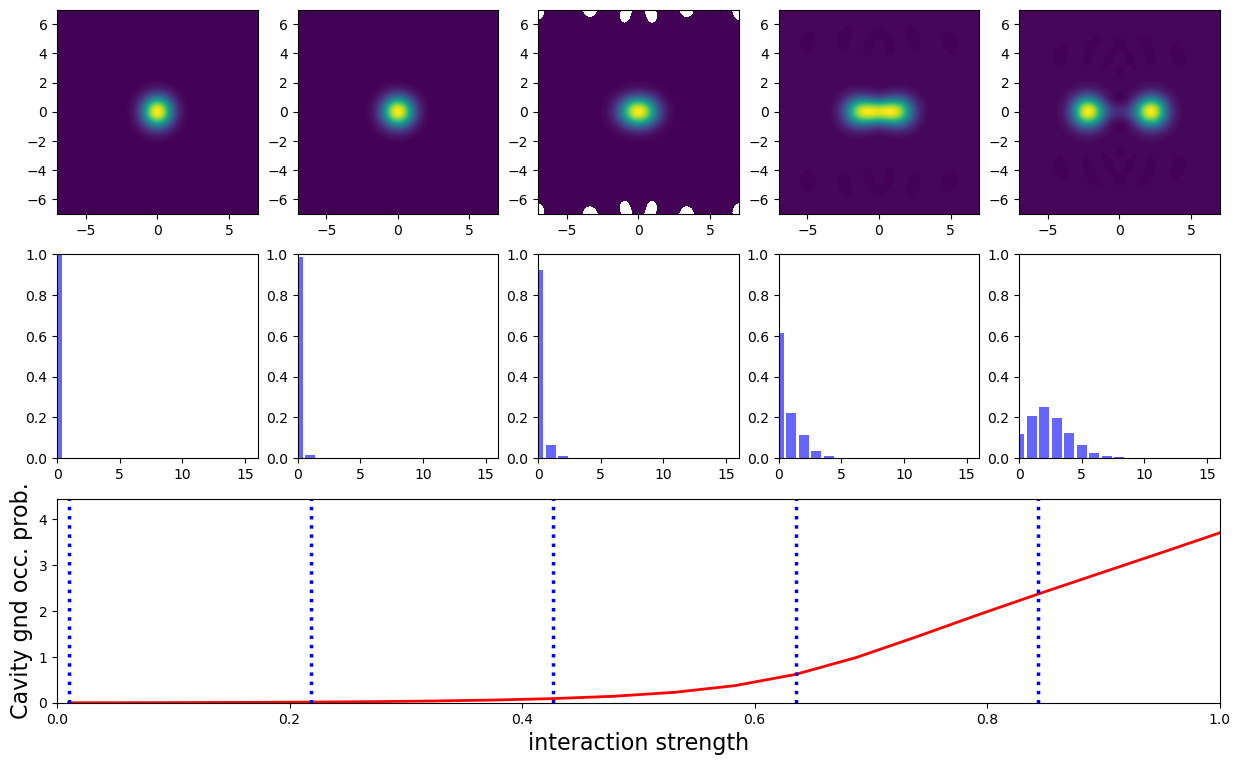

In [8]:
psi_gnd_sublist = psi_gnd_list[::4]

xvec = np.linspace(-7, 7, 200)

fig_grid = (3, len(psi_gnd_sublist))
fig = plt.figure(figsize=(3 * len(psi_gnd_sublist), 9))

for idx, psi_gnd in enumerate(psi_gnd_sublist):

    # trace out the cavity density matrix
    rho_gnd_cavity = ptrace(psi_gnd, 0)

    # calculate its wigner function
    W = wigner(rho_gnd_cavity, xvec, xvec)

    # plot its wigner function
    ax = plt.subplot2grid(fig_grid, (0, idx))
    ax.contourf(xvec, xvec, W, 100)

    # plot its fock-state distribution
    ax = plt.subplot2grid(fig_grid, (1, idx))
    ax.bar(np.arange(0, M), np.real(rho_gnd_cavity.diag()),
           color="blue", alpha=0.6)
    ax.set_ylim(0, 1)
    ax.set_xlim(0, M)

# plot the cavity occupation probability in the ground state
ax = plt.subplot2grid(fig_grid, (2, 0), colspan=fig_grid[1])
ax.plot(g_vec, n_gnd_vec, "r", linewidth=2, label="cavity occupation")
ax.set_xlim(0, max(g_vec))
ax.set_ylim(0, max(n_gnd_vec) * 1.2)
ax.set_ylabel("Cavity gnd occ. prob.", fontsize=16)
ax.set_xlabel("interaction strength", fontsize=16)

for g in g_vec[::4]:
    ax.plot([g, g], [0, max(n_gnd_vec) * 1.2], "b:", linewidth=2.5)

### Entropy/Entanglement between spins and cavity

In [9]:
entropy_tot = np.zeros(g_vec.shape)
entropy_cavity = np.zeros(g_vec.shape)
entropy_spin = np.zeros(g_vec.shape)

for idx, psi_gnd in enumerate(psi_gnd_list):

    rho_gnd_cavity = ptrace(psi_gnd, 0)
    rho_gnd_spin = ptrace(psi_gnd, 1)

    entropy_tot[idx] = entropy_vn(psi_gnd, 2)
    entropy_cavity[idx] = entropy_vn(rho_gnd_cavity, 2)
    entropy_spin[idx] = entropy_vn(rho_gnd_spin, 2)

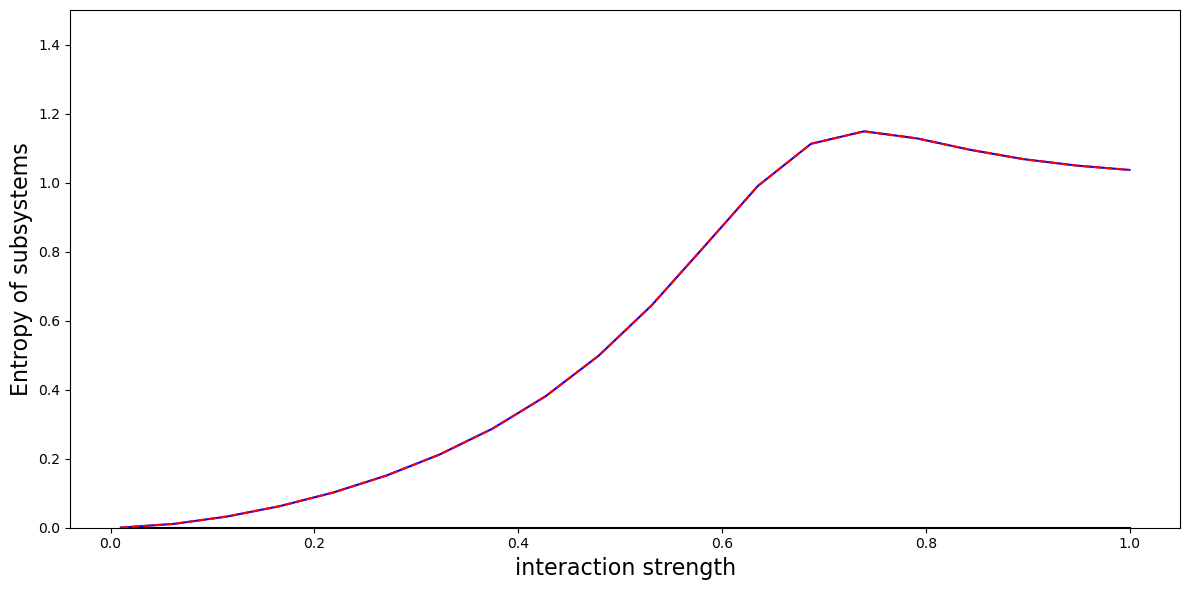

In [10]:
fig, axes = plt.subplots(1, 1, figsize=(12, 6))
axes.plot(
    g_vec, entropy_tot, "k", g_vec, entropy_cavity, "b", g_vec,
    entropy_spin, "r--"
)

axes.set_ylim(0, 1.5)
axes.set_ylabel("Entropy of subsystems", fontsize=16)
axes.set_xlabel("interaction strength", fontsize=16)

fig.tight_layout()

# Entropy as a function interaction strength for increasing N

### References

* [Lambert et al., Phys. Rev. Lett. 92, 073602 (2004)](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.92.073602).

In [11]:
def calculate_entropy(M, N, g_vec):

    j = N / 2.0
    n = 2 * j + 1

    # setup the hamiltonian for the requested hilbert space sizes
    a = tensor(destroy(M), qeye(int(n)))
    Jp = tensor(qeye(M), jmat(j, "+"))
    Jm = tensor(qeye(M), jmat(j, "-"))
    Jz = tensor(qeye(M), jmat(j, "z"))

    H0 = w * a.dag() * a + w0 * Jz
    H1 = 1.0 / np.sqrt(N) * (a + a.dag()) * (Jp + Jm)

    # Ground state and steady state for the Hamiltonian: H = H0 + g * H1
    psi_gnd_list = [(H0 + g * H1).groundstate()[1] for g in g_vec]

    entropy_cavity = np.zeros(g_vec.shape)
    entropy_spin = np.zeros(g_vec.shape)

    for idx, psi_gnd in enumerate(psi_gnd_list):

        rho_gnd_cavity = ptrace(psi_gnd, 0)
        rho_gnd_spin = ptrace(psi_gnd, 1)

        entropy_cavity[idx] = entropy_vn(rho_gnd_cavity, 2)
        entropy_spin[idx] = entropy_vn(rho_gnd_spin, 2)

    return entropy_cavity, entropy_spin

/home/runner/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/qutip/core/qobj.py:1810: UserWarning: Ground state may be degenerate.
  warnings.warn("Ground state may be degenerate.", UserWarning)


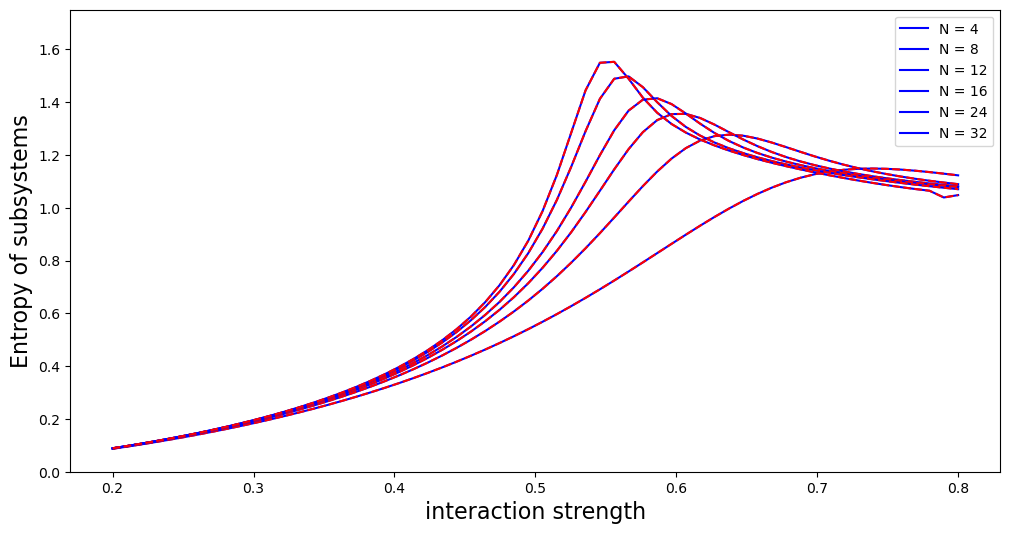

In [12]:
g_vec = np.linspace(0.2, 0.8, 60)
N_vec = [4, 8, 12, 16, 24, 32]
MM = 25

fig, axes = plt.subplots(1, 1, figsize=(12, 6))

for NN in N_vec:

    entropy_cavity, entropy_spin = calculate_entropy(MM, NN, g_vec)

    axes.plot(g_vec, entropy_cavity, "b", label="N = %d" % NN)
    axes.plot(g_vec, entropy_spin, "r--")

axes.set_ylim(0, 1.75)
axes.set_ylabel("Entropy of subsystems", fontsize=16)
axes.set_xlabel("interaction strength", fontsize=16)
axes.legend();

# Dissipative cavity: steady state instead of the ground state

In [13]:
# average number thermal photons in the bath coupling to the resonator
n_th = 0.25

c_ops = [np.sqrt(kappa * (n_th + 1)) * a, np.sqrt(kappa * n_th) * a.dag()]
# c_ops = [sqrt(kappa) * a, sqrt(gamma) * Jm]

## Find the ground state as a function of cavity-spin interaction strength

In [14]:
g_vec = np.linspace(0.01, 1.0, 20)

# Ground state for the Hamiltonian: H = H0 + g * H1
rho_ss_list = [steadystate(H0 + g * H1, c_ops) for g in g_vec]

## Cavity ground state occupation probability

In [15]:
# calculate the expectation value of the number of photons in the cavity
n_ss_vec = expect(a.dag() * a, rho_ss_list)

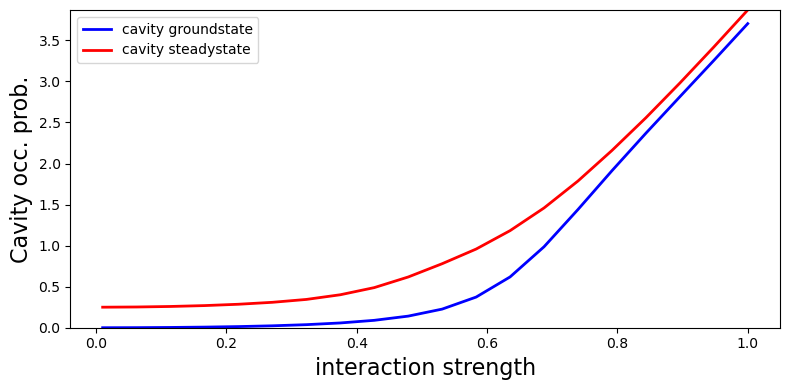

In [16]:
fig, axes = plt.subplots(1, 1, sharex=True, figsize=(8, 4))

axes.plot(g_vec, n_gnd_vec, "b", linewidth=2, label="cavity groundstate")
axes.plot(g_vec, n_ss_vec, "r", linewidth=2, label="cavity steadystate")
axes.set_ylim(0, max(n_ss_vec))
axes.set_ylabel("Cavity occ. prob.", fontsize=16)
axes.set_xlabel("interaction strength", fontsize=16)
axes.legend(loc=0)

fig.tight_layout()

## Cavity Wigner function and Fock distribution as a function of coupling strength

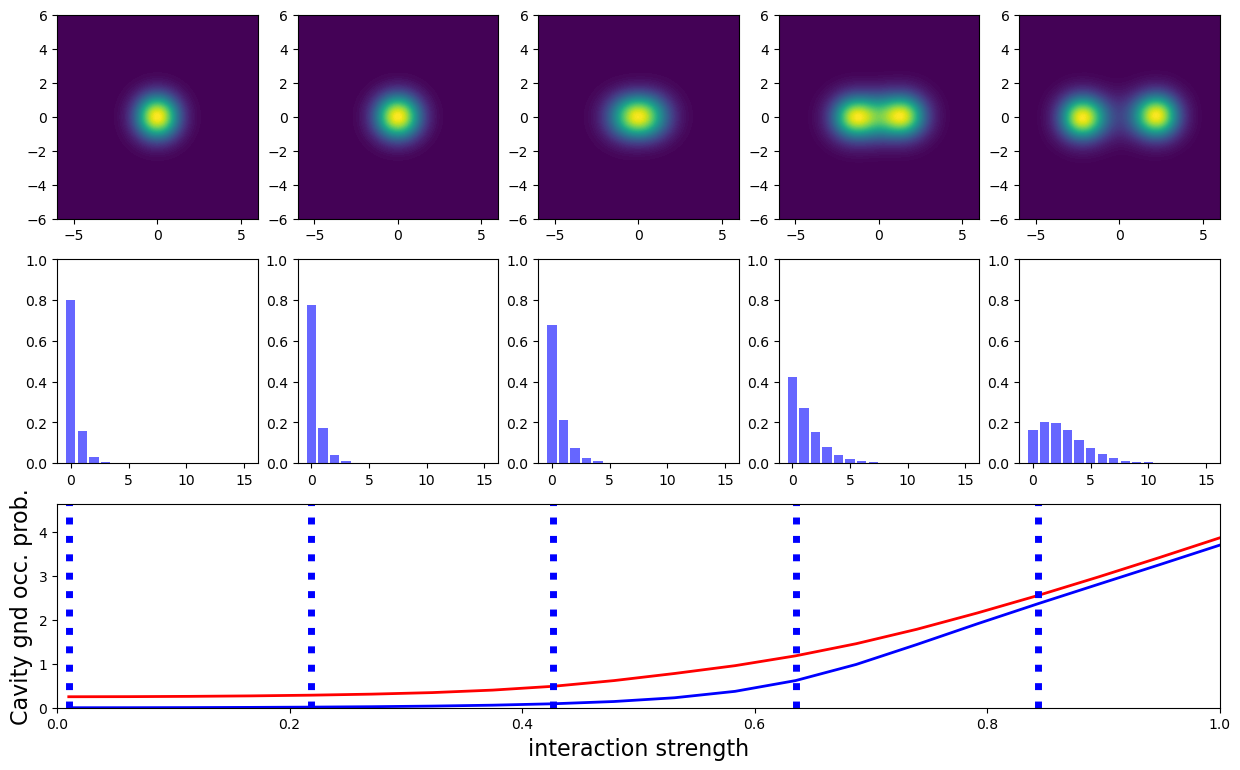

In [17]:
rho_ss_sublist = rho_ss_list[::4]

xvec = np.linspace(-6, 6, 200)

fig_grid = (3, len(rho_ss_sublist))
fig = plt.figure(figsize=(3 * len(rho_ss_sublist), 9))

for idx, rho_ss in enumerate(rho_ss_sublist):

    # trace out the cavity density matrix
    rho_ss_cavity = ptrace(rho_ss, 0)

    # calculate its wigner function
    W = wigner(rho_ss_cavity, xvec, xvec)

    # plot its wigner function
    ax = plt.subplot2grid(fig_grid, (0, idx))
    ax.contourf(xvec, xvec, W, 100)

    # plot its fock-state distribution
    ax = plt.subplot2grid(fig_grid, (1, idx))
    ax.bar(np.arange(0, M), np.real(rho_ss_cavity.diag()), color="blue",
           alpha=0.6)
    ax.set_ylim(0, 1)

# plot the cavity occupation probability in the ground state
ax = plt.subplot2grid(fig_grid, (2, 0), colspan=fig_grid[1])
ax.plot(g_vec, n_gnd_vec, "b", linewidth=2, label="cavity groundstate")
ax.plot(g_vec, n_ss_vec, "r", linewidth=2, label="cavity steadystate")
ax.set_xlim(0, max(g_vec))
ax.set_ylim(0, max(n_ss_vec) * 1.2)
ax.set_ylabel("Cavity gnd occ. prob.", fontsize=16)
ax.set_xlabel("interaction strength", fontsize=16)

for g in g_vec[::4]:
    ax.plot([g, g], [0, max(n_ss_vec) * 1.2], "b:", linewidth=5)

## Entropy

In [18]:
entropy_tot = np.zeros(g_vec.shape)
entropy_cavity = np.zeros(g_vec.shape)
entropy_spin = np.zeros(g_vec.shape)

for idx, rho_ss in enumerate(rho_ss_list):

    rho_gnd_cavity = ptrace(rho_ss, 0)
    rho_gnd_spin = ptrace(rho_ss, 1)

    entropy_tot[idx] = entropy_vn(rho_ss, 2)
    entropy_cavity[idx] = entropy_vn(rho_gnd_cavity, 2)
    entropy_spin[idx] = entropy_vn(rho_gnd_spin, 2)

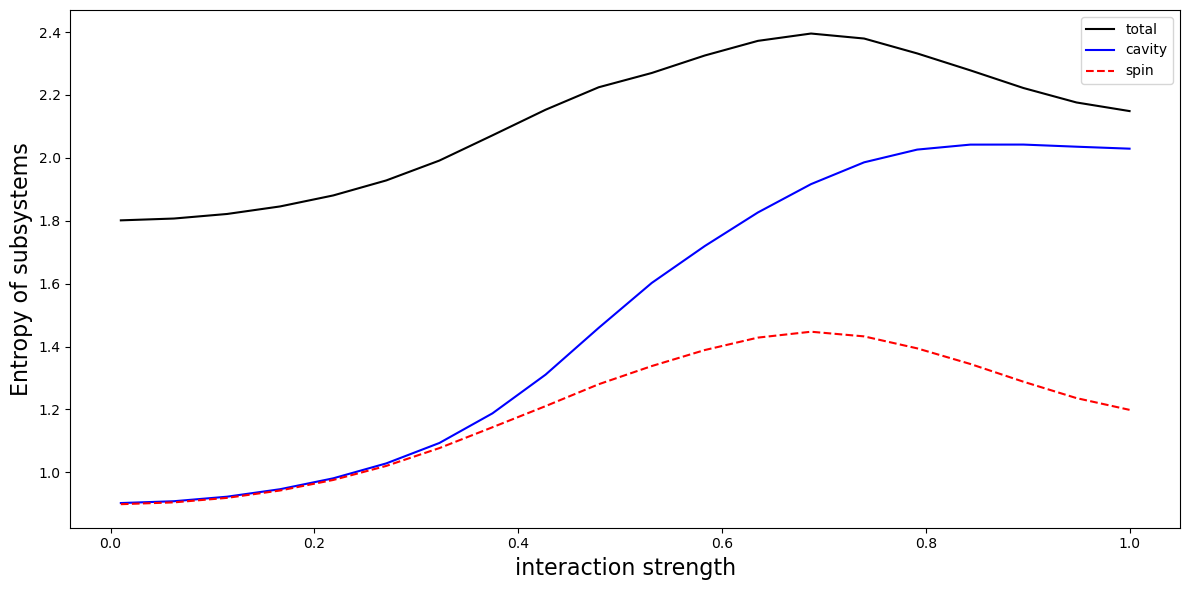

In [19]:
fig, axes = plt.subplots(1, 1, figsize=(12, 6))

axes.plot(g_vec, entropy_tot, "k", label="total")
axes.plot(g_vec, entropy_cavity, "b", label="cavity")
axes.plot(g_vec, entropy_spin, "r--", label="spin")

axes.set_ylabel("Entropy of subsystems", fontsize=16)
axes.set_xlabel("interaction strength", fontsize=16)
axes.legend(loc=0)
fig.tight_layout()

### Software versions

In [20]:
about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Current admin team: Alexander Pitchford, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, Eric Giguère, Boxi Li, Simon Cross, Asier Galicia, Paul Menczel, and Patrick Hopf.
Board members: Daniel Burgarth, Robert Johansson, Anton F. Kockum, Franco Nori and Will Zeng.
Original developers: R. J. Johansson & P. D. Nation.
Previous lead developers: Chris Granade & A. Grimsmo.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      5.3.0.dev0+6e4b53d
Numpy Version:      2.3.5
Scipy Version:      1.16.3
Cython Version:     3.2.2
Matplotlib Version: 3.10.8
Python Version:     3.12.0
Number of CPUs:     4
BLAS Info:          blas
INTEL MKL Ext:      None
Platform Info:      Linux (x86_64)
Installation path:  /home/runner/miniconda3/envs/test-environment-v5/lib/python3.12/site-packages/qutip

Installed QuTiP family packages
-------------------------------

qutip-qtrl: 

qutip-jax: 0.1.1.dev6
qutip-qip: 0.5.0.dev0+81a92b9

Please cite QuTiP in your publication.
For your convenience a bibtex reference can be easily generated using `qutip.cite()`
